<a href="https://colab.research.google.com/github/Harshpreetkaur98/Brain-Tumour-MRI-Detection/blob/main/BrainTumourMRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading Required Libraries

In [1]:
!pip install matplotlib seaborn numpy pandas opencv-python scikit-learn pillow

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ---------------------------------------- 8.0/8.0 MB 70.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/12.6 MB ? eta -:--:--
   ---------------------------------------  12.6/12.6 MB 60.7 MB/s eta 0:00:01
   ---------------------------------------- 12.6/12.6 MB 56.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/11.5 MB ? eta -:--:--
   ----------------------------------- ---- 10.2/11.5 MB 45.5 MB/s eta 0:00:01
   ---------------------------------------- 11.5/11.5 MB 45.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------- ----------------------------- 10.0/39.5 MB 44.3 MB/s eta 0:00:01
   ------------------- -------------------- 19.4/39.5 MB 45.3 MB/s eta 0:00:01
   -------------------------------- ------- 32.0/39.5 MB 50.8 MB/s eta 0:00:01
   ----------


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


CUDA is not available. Running on CPU.


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

Loading and Inspecting Dataset Structure

In [3]:
data_dir = "Data/Training"

# Getting the class names (glioma, notumour, meninglioma, pituitary)
class_names = os.listdir(data_dir)
print("Classes:", class_names)

# Counting the number of images in each class
class_counts = {cls: len(os.listdir(os.path.join(data_dir, cls))) for cls in class_names}
print("Image count per class:", class_counts)

# Converting to a DataFrame for easy visualization
df_counts = pd.DataFrame(list(class_counts.items()), columns=["Class", "Image Count"])


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Image count per class: {'glioma': 1849, 'meningioma': 1874, 'notumor': 2233, 'pituitary': 2039}


Displaying Sample Images from Each Category

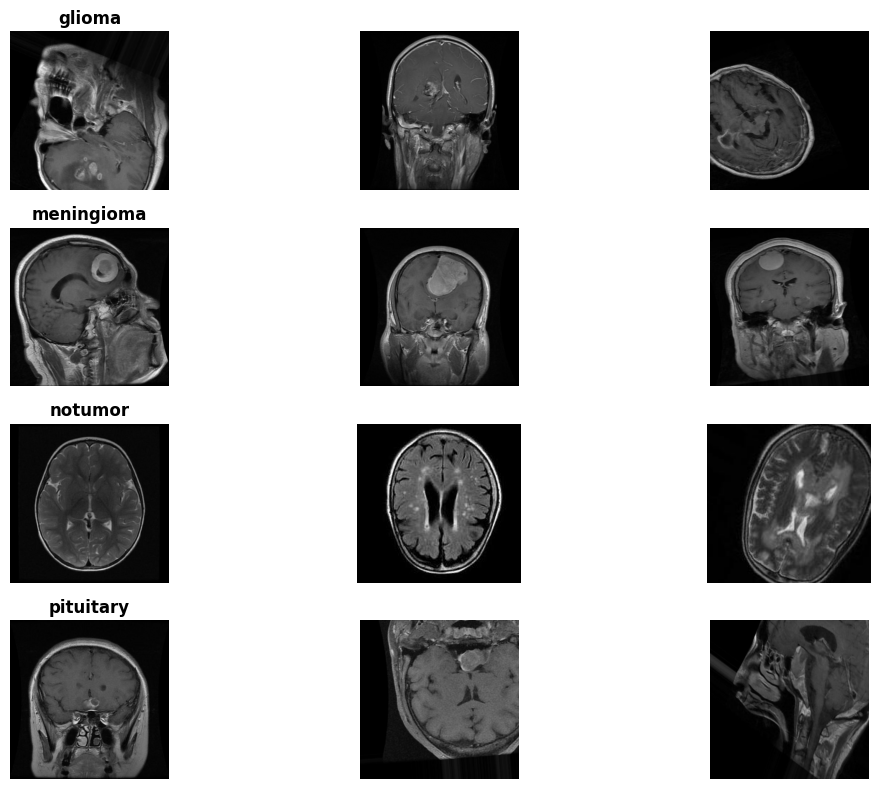

In [4]:
def display_sample_images(data_dir, class_names, num_samples=3):

    # Creating a figure with subplots: rows = classes, columns = num_samples
    fig, axes = plt.subplots(len(class_names), num_samples, figsize=(12, 8))

    for i, cls in enumerate(class_names):
        class_path = os.path.join(data_dir, cls)
        image_files = os.listdir(class_path)  # Get all images in the folder

        # Handling cases where a class has fewer images than num_samples
        if len(image_files) < num_samples:
            print(f"⚠️ Warning: Class '{cls}' has only {len(image_files)} images (Expected: {num_samples})")
            selected_images = image_files
        else:
            selected_images = np.random.choice(image_files, num_samples, replace=False)

        for j in range(num_samples):
            if j < len(selected_images):
                img_path = os.path.join(class_path, selected_images[j])

                try:
                    # Opening and displaying the image
                    img = Image.open(img_path)
                    axes[i, j].imshow(img, cmap="gray")
                    axes[i, j].axis("off")
                except Exception as e:
                    print(f"❌ Error loading image {img_path}: {e}")
                    axes[i, j].axis("off")

            # Setting the title only for the first image in each row (class name)
            if j == 0:
                axes[i, j].set_title(cls, fontsize=12, fontweight="bold")

    # Adjusting layout for better spacing
    plt.tight_layout()
    plt.show()

display_sample_images(data_dir, class_names)

Checking Image Dimensions and Formats

            Width      Height
count   20.000000   20.000000
mean   494.250000  496.350000
std     85.938702   85.953032
min    220.000000  212.000000
25%    512.000000  512.000000
50%    512.000000  512.000000
75%    512.000000  512.000000
max    630.000000  630.000000


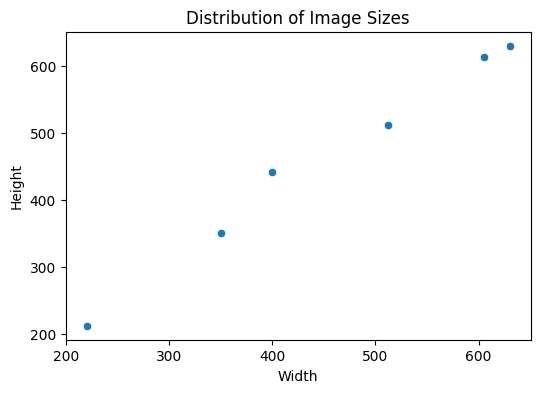

In [5]:
image_shapes = []

for cls in class_names:
    class_path = os.path.join(data_dir, cls)
    sample_images = os.listdir(class_path)[:5] # Checking for first 5 images only

    for img_name in sample_images:
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path)
        image_shapes.append(img.size)

# Converting to a dataframe for better readability
df_shapes = pd.DataFrame(image_shapes, columns=["Width", "Height"])
print(df_shapes.describe())

# Plotting distribution of image sizes
plt.figure(figsize=(6, 4))
sns.scatterplot(x=df_shapes["Width"], y=df_shapes["Height"])
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Distribution of Image Sizes")
plt.show()

Performing Class Distribution Analysis

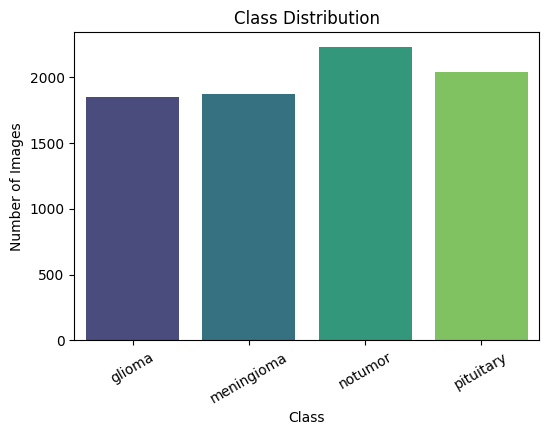

In [6]:
# Using bar graph for better visualization
plt.figure(figsize=(6, 4))

sns.barplot(data=df_counts, x="Class", y="Image Count", hue="Class", palette="viridis", legend=False)

plt.xticks(rotation=30)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution")

plt.show()

Histogram for Pixel Intensities

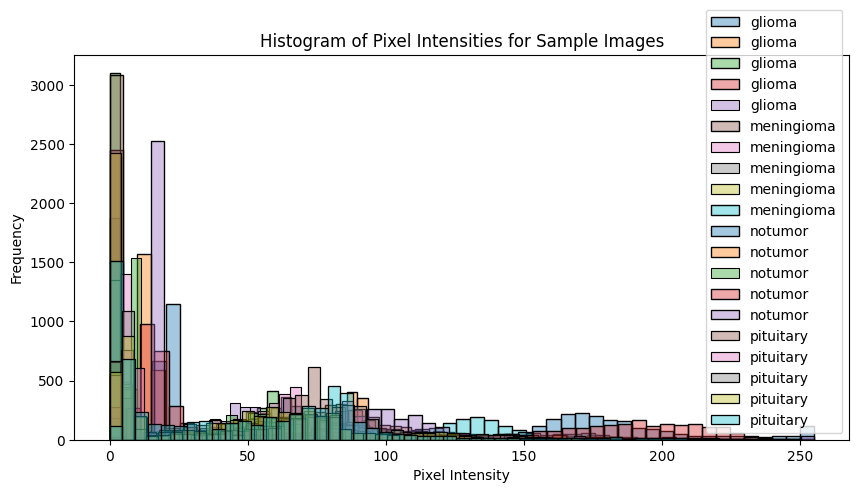

In [7]:
def plot_pixel_histogram(data_dir, class_names, num_samples=5, img_resize=(128, 128), kde=False, sample_pixels=5000):

    plt.figure(figsize=(10, 5))

    for cls in class_names:
        class_path = os.path.join(data_dir, cls)
        image_files = os.listdir(class_path)

        # Handling edge case where class has fewer images than num_samples
        if len(image_files) < num_samples:
            print(f"⚠️ Warning: '{cls}' has only {len(image_files)} images. Using all available.")
            selected_images = image_files
        else:
            selected_images = np.random.choice(image_files, num_samples, replace=False)

        for img_name in selected_images:
            img_path = os.path.join(class_path, img_name)

            try:
                img = Image.open(img_path).convert("L")  
                img = img.resize(img_resize)  
                img_array = np.array(img).flatten()

                if len(img_array) > sample_pixels:
                    img_array = np.random.choice(img_array, sample_pixels, replace=False)

                # Plotting histogram
                sns.histplot(img_array, bins=50, kde=kde, alpha=0.4, label=cls)

            except Exception as e:
                print(f"❌ Error loading image {img_path}: {e}")
                continue

    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title("Histogram of Pixel Intensities for Sample Images")
    plt.show()

plot_pixel_histogram(data_dir, class_names)

t-SNE/PCA for high-dimensional feature visualistion

In [8]:
def load_images_for_pca(data_dir, class_names, max_samples=100):

    image_data = []
    labels = []

    for cls in class_names:
        class_path = os.path.join(data_dir, cls)

        image_files = os.listdir(class_path)

        if len(image_files) == 0:
            print(f"⚠️ No images found in class '{cls}'. Skipping.")
            continue

        sample_images = np.random.choice(image_files, min(len(image_files), max_samples), replace=False)

        print(f"Loading {len(sample_images)} images from class '{cls}'...")

        for img_name in sample_images:
            img_path = os.path.join(class_path, img_name)

            try:
                # Opening and process the image
                img = Image.open(img_path).convert("L")  
                img = img.resize((64, 64))  
                img_array = np.array(img).flatten()  # Flattening to 1D array

                image_data.append(img_array)
                labels.append(cls)

            except Exception as e:
                print(f"❌ Error loading image {img_path}: {e}")

    # Converting to numpy array for PCA processing
    if len(image_data) == 0:
        print("⚠️ No images were successfully loaded. Check your dataset.")
        return np.array([]), []

    return np.array(image_data), labels

X, y = load_images_for_pca(data_dir, class_names)

# Checking the shapes of the returned data
if X.size == 0:
    print("⚠️ No data loaded for PCA.")
else:
    print(f"Image data shape: {X.shape}")
    print(f"Labels: {y[:5]}")  


Loading 100 images from class 'glioma'...
Loading 100 images from class 'meningioma'...
Loading 100 images from class 'notumor'...
Loading 100 images from class 'pituitary'...
Image data shape: (400, 4096)
Labels: ['glioma', 'glioma', 'glioma', 'glioma', 'glioma']


☁☁☁☁☁☁☁☁☁☁☁☁☁☁☁☁☁☁☁☁☁☁☁☁☁☁☁☁☁☁☁☁☁☁☁☁☁☁

DATA PREPROCESSING

☁☁☁☁☁☁☁☁☁☁☁☁☁☁☁☁☁☁☁☁☁☁☁☁☁☁☁☁☁☁☁☁☁☁☁☁☁☁

Converting Image to grayscale

In [40]:
from PIL import Image
import numpy as np

def convert_to_grayscale(image_path):
    img = Image.open(image_path).convert("L") 
    img_array = np.array(img)
    return img_array

Resizing Images to unifrom dimension (224X224)

In [41]:
def resize_image(image, target_size=(224, 224)):
    img_resized = image.resize(target_size)  
    return np.array(img_resized)

Normalising Pixel values to the range [0,1]

In [42]:
def normalize_0_1(img_array):
    return img_array / 255.0

Augmenting training data using

In [1]:
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize ImageDataGenerator with various augmentations
datagen = ImageDataGenerator(
    rotation_range=30,           # Rotation
    width_shift_range=0.2,       # Horizontal shift
    height_shift_range=0.2,      # Vertical shift
    shear_range=0.2,             # Shear
    zoom_range=0.2,              # Zoom
    horizontal_flip=True,        # Horizontal flip
    vertical_flip=True,          # Vertical flip
    brightness_range=[0.8, 1.2], # Brightness adjustments
    fill_mode='nearest'          # Fill mode
)

# Define paths
data_dir = "Data/Training"
augmented_dir = "Data/augmented"  # Parent directory to store all augmented images

# Create the folder for augmented images if it doesn't exist
os.makedirs(augmented_dir, exist_ok=True)

# List all class names
class_names = os.listdir(data_dir)

# Iterate over each class and apply augmentation
for cls in class_names:
    class_path = os.path.join(data_dir, cls)  # Path to the current class folder
    augmented_class_folder = os.path.join(augmented_dir, f"augmented_{cls}")
    
    # Create the folder for augmented images of the current class if it doesn't exist
    os.makedirs(augmented_class_folder, exist_ok=True)
    
    image_files = os.listdir(class_path)     # List of image files in the class folder
    
    # Determine how many images to augment (40% of the images)
    num_images_to_augment = int(len(image_files) * 0.4)
    
    # Shuffle the image files to select a random subset of images for augmentation
    random.shuffle(image_files)
    augmented_images = image_files[:num_images_to_augment]
    
    for img_name in augmented_images:
        img_path = os.path.join(class_path, img_name)  # Full path to the image
        img = Image.open(img_path)  # Open the image
        
        # Ensure the image is in grayscale (single channel)
        img = img.convert("L")  # Convert to grayscale if not already
        
        img_array = np.array(img)   # Convert to numpy array
        
        # Convert grayscale image to 3-channel by repeating the single channel (grayscale) across 3 channels
        img_array = np.stack([img_array] * 3, axis=-1)  # Shape: (height, width, 3)
        
        # Add batch dimension to the image array (required by Keras)
        img_array = np.expand_dims(img_array, axis=0)  # Shape: (1, height, width, 3)
        
        # Apply augmentations using ImageDataGenerator
        augmented_images_gen = datagen.flow(img_array, batch_size=1)  # Apply augmentation with batch size 1
        
        # Get augmented image
        augmented_img = next(augmented_images_gen)  # Get the next augmented image
        
        # Convert augmented numpy array to image and save it
        augmented_image = Image.fromarray(augmented_img[0].astype('uint8'))
        augmented_image.save(os.path.join(augmented_class_folder, f"augmented_{img_name}"))
        
        # Optionally, display the augmented image
        plt.imshow(augmented_img[0].astype('uint8'))
        plt.title(f"Augmented Image - Class: {cls}, Image: {img_name}")
        plt.show()

print("Augmentation process completed for all classes!")


KeyboardInterrupt: 

Splitting dataset into Traning, Validation, and Test Sets

In [1]:
import os
from PIL import Image

# Specify the path to your data folder
data_folder = 'Data/Training'  # Change this to your actual folder path

# List all the class folders
classes = os.listdir(data_folder)

# Initialize a dictionary to store the count of images per class
image_counts = {}

# Loop through each class folder
for class_name in classes:
    class_folder = os.path.join(data_folder, class_name)
    if os.path.isdir(class_folder):
        # Count the image files in each class folder (you can add specific filters for image extensions)
        image_files = [f for f in os.listdir(class_folder) if f.lower().endswith(('png', 'jpg', 'jpeg', 'gif', 'bmp'))]
        image_counts[class_name] = len(image_files)

# Display the results
for class_name, count in image_counts.items():
    print(f'Class: {class_name}, Number of images: {count}')


Class: glioma, Number of images: 1849
Class: meningioma, Number of images: 1874
Class: notumor, Number of images: 2233
Class: pituitary, Number of images: 2039


In [7]:
#  Equalising the number of images in each class


import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img


# List of classes
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Number of images in the largest class
max_images = 2233

# Image augmentation configurations
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to augment only the last few images in a class
def augment_images(class_name, class_folder, augment_count=20):
    class_path = os.path.join(data_folder, class_name)
    
    # List image files in the class folder (filter by image extensions)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('png', 'jpg', 'jpeg', 'gif', 'bmp'))]
    
    # Sort the images in lexicographical order (or you could sort by file date or name, depending on your needs)
    image_files.sort()
    
    # Get the last `augment_count` images
    images_to_augment = image_files[-augment_count:]

    # Loop through the images to augment
    for image_file in images_to_augment:
        img_path = os.path.join(class_path, image_file)
        img = load_img(img_path)  # Load the image
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        
        # Create augmented images and save them back to the same folder
        count = 0
        for _ in datagen.flow(img_array, batch_size=1, save_to_dir=class_path, save_prefix='aug', save_format='jpeg'):
            count += 1
            if count >= (max_images - len(image_files)):  # Stop when we've augmented enough images
                break

# Augment images for each class
for class_name in classes:
    augment_images(class_name, data_folder)


In [9]:
import os
from PIL import Image

# Specify the path to your data folder
data_folder = 'Data/Training'  # Change this to your actual folder path

# List all the class folders
classes = os.listdir(data_folder)

# Initialize a dictionary to store the count of images per class
image_counts = {}

# Loop through each class folder
for class_name in classes:
    class_folder = os.path.join(data_folder, class_name)
    if os.path.isdir(class_folder):
        # Count the image files in each class folder (you can add specific filters for image extensions)
        image_files = [f for f in os.listdir(class_folder) if f.lower().endswith(('png', 'jpg', 'jpeg', 'gif', 'bmp'))]
        image_counts[class_name] = len(image_files)

# Display the results
for class_name, count in image_counts.items():
    print(f'Class: {class_name}, Number of images: {count}')


Class: glioma, Number of images: 7128
Class: meningioma, Number of images: 7001
Class: notumor, Number of images: 2253
Class: pituitary, Number of images: 5249


In [19]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# Path to the data folder (update with your actual path)

# Class to augment (only the 'notumor' class in this case)
class_name = 'notumor'

# Number of images to augment
augment_count = 2500

# Image augmentation configurations
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to augment only the last N images and generate additional images
def augment_images(class_name, class_folder, augment_count=2500):
    class_path = os.path.join(data_folder, class_name)
    
    # List image files in the class folder (filter by image extensions)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('png', 'jpg', 'jpeg', 'gif', 'bmp'))]
    
    # Sort the images in lexicographical order (or you could sort by file date or name)
    image_files.sort()
    
    # Get the last `augment_count` images
    images_to_augment = image_files[-augment_count:]

    # Loop through the images to augment
    count = 0
    for image_file in images_to_augment:
        img_path = os.path.join(class_path, image_file)
        img = load_img(img_path)  # Load the image
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        
        # Create augmented images and save them back to the same folder
        for _ in datagen.flow(img_array, batch_size=1, save_to_dir=class_path, save_prefix='aug', save_format='jpeg'):
            count += 1
            if count >= augment_count:  # Stop once we've generated enough augmented images
                break

# Augment images for the 'notumor' class only
augment_images(class_name, data_folder, augment_count)


In [12]:
import os
from PIL import Image

# Specify the path to your data folder
data_folder = 'Data/Training'  # Change this to your actual folder path

# List all the class folders
classes = os.listdir(data_folder)

# Initialize a dictionary to store the count of images per class
image_counts = {}

# Loop through each class folder
for class_name in classes:
    class_folder = os.path.join(data_folder, class_name)
    if os.path.isdir(class_folder):
        # Count the image files in each class folder (you can add specific filters for image extensions)
        image_files = [f for f in os.listdir(class_folder) if f.lower().endswith(('png', 'jpg', 'jpeg', 'gif', 'bmp'))]
        image_counts[class_name] = len(image_files)

# Display the results
for class_name, count in image_counts.items():
    print(f'Class: {class_name}, Number of images: {count}')


Class: glioma, Number of images: 5000
Class: meningioma, Number of images: 5000
Class: notumor, Number of images: 5000
Class: pituitary, Number of images: 5000


Implementing Constrast Enhancement (CLAHE, Contrast Limited Adaptive Histogram Equalisation)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
Using Image segmentation

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Use the original and augmented data for training
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    'Data/Training',  # Path to your combined original and augmented images directory
    target_size=(224, 224),  # Resize images to match ResNet50 input size
    batch_size=32,
    class_mode='categorical'  # Multi-class classification
)

# Load the test (validation) data (from the original training folder, without augmentation)
validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    'Data/Training',  # Path to your original training folder (no augmentation)
    target_size=(224, 224),  # Resize
    batch_size=32,
    class_mode='categorical'  # Multi-class classification
)

Found 20000 images belonging to 4 classes.
Found 20000 images belonging to 4 classes.
